<a href="https://colab.research.google.com/github/Obsinaan/2015lab3/blob/master/pytorch_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q imutils

# Pytorch U-net implementation report

* This is the implementation for the challenge https://www.kaggle.com/competitions/tgs-salt-identification-challenge
* You may access this notebook online via: https://www.kaggle.com/code/rathgrith/pytorch-unet

## Utilities

In [1]:
# import the necessary packages
import os
import time

import cv2
import zipfile

import torch
from torch.nn import ReLU
from torch.nn import Conv2d
from torch.nn import Module
from torch.optim import Adam
from torch.nn import MaxPool2d
from torch.nn import ModuleList
from torchvision import transforms
from torch.utils.data import Dataset
from torch.nn import ConvTranspose2d
from torch.nn import functional as F
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader
from torchvision.transforms import CenterCrop

from sklearn.model_selection import train_test_split


from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Files are then loaded after the packages imported.

In [7]:
z= zipfile.ZipFile('/content/drive/MyDrive/Segmentation/competition_data.zip')
z.extractall()

In [8]:
# base path of the dataset
DATASET_PATH = "./competition_data/train/"

# define the path to the images and masks dataset
IMAGE_DATASET_PATH = os.path.join(DATASET_PATH, "images")
MASK_DATASET_PATH = os.path.join(DATASET_PATH, "masks")

# define the test split
TEST_SPLIT = 0.15

# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

## Visualization

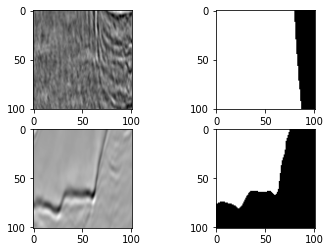

In [9]:
from PIL import Image
im = Image.open(IMAGE_DATASET_PATH + "/7cc53fe88b.png")
plt.subplot(2,2,1)
plt.imshow(im)
im = Image.open(MASK_DATASET_PATH + "/7cc53fe88b.png")
plt.subplot(2,2,2)
plt.imshow(im)
im = Image.open(IMAGE_DATASET_PATH + "/9ca520f895.png")
plt.subplot(2,2,3)
plt.imshow(im)
im = Image.open(MASK_DATASET_PATH + "/9ca520f895.png")
plt.subplot(2,2,4)
plt.imshow(im)

In [12]:
 #!ls ./competition_data/train/images
#!ls ./competition_data/train/masks

## Dataset

In [13]:
# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 3

# initialize learning rate, number of epochs to train for, and the batch size
INIT_LR = 0.001
NUM_EPOCHS = 40
BATCH_SIZE = 64

# define the input image dimensions
# Crop
INPUT_IMAGE_WIDTH = 128
INPUT_IMAGE_HEIGHT = 128

# define threshold to filter weak predictions
THRESHOLD = 0.5

# define the path to the base output directory
BASE_OUTPUT = "output"

# define the path to the output serialized model, model training plot, and testing image paths
MODEL_PATH = "unet_tgs_salt.pth"
PLOT_PATH = "plot.png"
TEST_PATHS = "test_paths.txt"

In [14]:
class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths, transforms):
		# store the image and mask filepaths, and augmentation transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths
		self.transforms = transforms
        
	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
    
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
        
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		mask = cv2.imread(self.maskPaths[idx], 0)
        
		# check to see if we are applying any transformations
		if self.transforms is not None:
			# apply the transformations to both image and its mask
			image = self.transforms(image)
			mask = self.transforms(mask)
            
		# return a tuple of the image and its mask
		return (image, mask)

## Model Structure

Similar to FCN, the overall structure of U-Net is also an Encoder-Decoder Structure, in which 3x3 convolution layers and 2x2 max-polling are used alternately for down sampling. In the end of the encoding the network will output a feature map which is then be used for decoding.

![](https://pic.imgdb.cn/item/625d8915239250f7c502d886.jpg)

As for the decoder, the decoder will concatenate cropped outputs of each encoder layer as new feature map, which is different to FCN (adding pixel values). Which can produce "thicker" feature. Noted that in the original paper, the input and output sizes are different. While by controlling convolution parameters, it is also possible to rebuild a output image of the same size to inputs.

In [15]:
class Block(Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		# store the convolution and RELU layers
		self.conv1 = Conv2d(inChannels, outChannels, 3)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, 3)
        
	def forward(self, x):
		# apply CONV => RELU => CONV block to the inputs and return it
		return self.conv2(self.relu(self.conv1(x)))

In [16]:
class Encoder(Module):
	def __init__(self, channels=(3, 16, 32, 64)):
		super().__init__()
		# store the encoder blocks and maxpooling layer
		self.encBlocks = ModuleList([Block(channels[i], channels[i + 1]) for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)
        
	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		blockOutputs = []
        
		# loop through the encoder blocks
		for block in self.encBlocks:
			# pass the inputs through the current encoder block, store the outputs, and then apply maxpooling on the output
			x = block(x)
            # add blocked x to the end
			blockOutputs.append(x)
            # pooling
			x = self.pool(x)
            
        # return the list containing the intermediate outputs
		return blockOutputs

With the encoder layer get deeper and deeper, the scope of feature map get larger and larger. 

i.e. Shallow layers cares about textural details while deeper layers consider the general features of an area, which are both contributing to the segmentaions.

Also, by concatenating, some lost marginal information are retrieved by reviewing encoding layers which are not recoverable by up-sampling. 

In [17]:
class Decoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
        
		# initialize the number of channels, upsampler blocks, and decoder blocks
		self.channels = channels
        # upconvolution 64 to 32, 32 to 16 respectively
		self.upconvs = ModuleList([ConvTranspose2d(channels[i], channels[i + 1], 2, 2) for i in range(len(channels) - 1)])
        # define 3*3 conv and RELU block
		self.dec_blocks = ModuleList([Block(channels[i], channels[i + 1]) for i in range(len(channels) - 1)])
        
	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
            
			# crop the current features from the encoder blocks, concatenate them with the current upsampled features,
			# and pass the concatenated output through the current decoder block
			encFeat = self.crop(encFeatures[i], x)
            # Concatenate!
			x = torch.cat([x, encFeat], dim=1)
            # 3*3 conv and RELU for each upscending layer.
			x = self.dec_blocks[i](x)
            
		# return the final decoder output
		return x
    
	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
        
		# return the cropped features
		return encFeatures

You may find that the feature maps are croped before the concatenation that is because of that there may be mismatch between the encoder dim and decoder dim. Thus, crop is essential to homogenize their dimensions.

In [18]:
class UNet(Module):
	def __init__(self, encChannels=(3, 16, 32, 64), decChannels=(64, 32, 16), nbClasses=1, retainDim=True, outSize=(INPUT_IMAGE_HEIGHT,  INPUT_IMAGE_WIDTH)):
		super().__init__()
		
		# initialize the encoder and decoder
		self.encoder = Encoder(encChannels)
		self.decoder = Decoder(decChannels)
		
		# initialize the regression head and store the class variables
		self.head = Conv2d(decChannels[-1], nbClasses, 1)
		self.retainDim = retainDim
		self.outSize = outSize
		
	def forward(self, x):
		# grab the features from the encoder
		encFeatures = self.encoder(x)
		
		# pass the encoder features through decoder making sure that their dimensions are suited for concatenation
        # last output as 1st decfeature and every
		decFeatures = self.decoder(encFeatures[::-1][0],encFeatures[::-1][1:])
		
		# pass the decoder features through the regression head to obtain the segmentation mask
		map_ = self.head(decFeatures)
		
		# check to see if we are retaining the original output dimensions and if so, then resize the output to match them
		if self.retainDim:
			map_ = F.interpolate(map_, self.outSize)
			
		# return the segmentation map
		return map_

## Training & Testing

In [19]:
# load the image and mask filepaths in a sorted manner
imagePaths = sorted(list(paths.list_images(IMAGE_DATASET_PATH)))
maskPaths = sorted(list(paths.list_images(MASK_DATASET_PATH)))

# partition the data into training and testing splits using 85% of the data for training and the remaining 15% for testing
split = train_test_split(imagePaths, maskPaths, test_size=TEST_SPLIT, random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]

# write the testing image paths to disk so that we can use then when evaluating/testing our model
print("[INFO] saving testing image paths...")
f = open("test_paths.txt", "w")
f.write("\n".join(testImages))
f.close()

[INFO] saving testing image paths...


In [20]:
# define transformations
transforms = transforms.Compose([transforms.ToPILImage(), transforms.Resize((INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH)), transforms.ToTensor()])

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks,	transforms=transforms)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks, transforms=transforms)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")

# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True,	batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY, num_workers=os.cpu_count())
testLoader = DataLoader(testDS, shuffle=False, batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY, num_workers=os.cpu_count())

[INFO] found 3400 examples in the training set...
[INFO] found 600 examples in the test set...


In [21]:
# initialize our UNet model
unet = UNet().to(DEVICE)

# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=INIT_LR)

# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE

# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [22]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
	# set the model in training mode
	unet.train()
    
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
    
	# loop over the training set
	for (i, (x, y)) in enumerate(trainLoader):
		# send the input to the device
		(x, y) = (x.to(DEVICE), y.to(DEVICE))
        
		# perform a forward pass and calculate the training loss
		pred = unet(x)
		loss = lossFunc(pred, y)
        
		# first, zero out any previously accumulated gradients, then perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
        
		# add the loss to the total training loss so far
		totalTrainLoss += loss
        
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
        
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
            
			# make the predictions and calculate the validation loss
			pred = unet(x)
			totalTestLoss += lossFunc(pred, y)
            
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps
    
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
    
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(avgTrainLoss, avgTestLoss))
    
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...


  2%|▎         | 1/40 [00:14<09:25, 14.49s/it]

[INFO] EPOCH: 1/40
Train loss: 0.593017, Test loss: 0.6111


  5%|▌         | 2/40 [00:23<07:17, 11.50s/it]

[INFO] EPOCH: 2/40
Train loss: 0.559369, Test loss: 0.5974


  8%|▊         | 3/40 [00:31<05:51,  9.50s/it]

[INFO] EPOCH: 3/40
Train loss: 0.560054, Test loss: 0.5805


 10%|█         | 4/40 [00:36<04:51,  8.11s/it]

[INFO] EPOCH: 4/40
Train loss: 0.518919, Test loss: 0.5273


 12%|█▎        | 5/40 [00:43<04:17,  7.37s/it]

[INFO] EPOCH: 5/40
Train loss: 0.453792, Test loss: 0.4498


 15%|█▌        | 6/40 [00:49<03:54,  6.90s/it]

[INFO] EPOCH: 6/40
Train loss: 0.451909, Test loss: 0.4370


 18%|█▊        | 7/40 [00:54<03:35,  6.53s/it]

[INFO] EPOCH: 7/40
Train loss: 0.414906, Test loss: 0.4591


 20%|██        | 8/40 [01:00<03:23,  6.35s/it]

[INFO] EPOCH: 8/40
Train loss: 0.422230, Test loss: 0.5480


 22%|██▎       | 9/40 [01:06<03:14,  6.28s/it]

[INFO] EPOCH: 9/40
Train loss: 0.426502, Test loss: 0.4227


 25%|██▌       | 10/40 [01:13<03:08,  6.29s/it]

[INFO] EPOCH: 10/40
Train loss: 0.410143, Test loss: 0.4042


 28%|██▊       | 11/40 [01:19<03:00,  6.22s/it]

[INFO] EPOCH: 11/40
Train loss: 0.400504, Test loss: 0.4037


 30%|███       | 12/40 [01:25<02:52,  6.15s/it]

[INFO] EPOCH: 12/40
Train loss: 0.392298, Test loss: 0.3992


 32%|███▎      | 13/40 [01:31<02:45,  6.12s/it]

[INFO] EPOCH: 13/40
Train loss: 0.408750, Test loss: 0.4050


 35%|███▌      | 14/40 [01:37<02:37,  6.07s/it]

[INFO] EPOCH: 14/40
Train loss: 0.391727, Test loss: 0.4257


 38%|███▊      | 15/40 [01:43<02:31,  6.06s/it]

[INFO] EPOCH: 15/40
Train loss: 0.394700, Test loss: 0.4025


 40%|████      | 16/40 [01:49<02:25,  6.05s/it]

[INFO] EPOCH: 16/40
Train loss: 0.381181, Test loss: 0.3853


 42%|████▎     | 17/40 [01:56<02:29,  6.50s/it]

[INFO] EPOCH: 17/40
Train loss: 0.376092, Test loss: 0.4049


 45%|████▌     | 18/40 [02:03<02:24,  6.57s/it]

[INFO] EPOCH: 18/40
Train loss: 0.381219, Test loss: 0.3866


 48%|████▊     | 19/40 [02:09<02:14,  6.42s/it]

[INFO] EPOCH: 19/40
Train loss: 0.375490, Test loss: 0.3894


 50%|█████     | 20/40 [02:15<02:05,  6.29s/it]

[INFO] EPOCH: 20/40
Train loss: 0.378695, Test loss: 0.3772


 52%|█████▎    | 21/40 [02:21<01:57,  6.18s/it]

[INFO] EPOCH: 21/40
Train loss: 0.367204, Test loss: 0.3774


 55%|█████▌    | 22/40 [02:27<01:49,  6.10s/it]

[INFO] EPOCH: 22/40
Train loss: 0.366066, Test loss: 0.3807


 57%|█████▊    | 23/40 [02:33<01:43,  6.08s/it]

[INFO] EPOCH: 23/40
Train loss: 0.365504, Test loss: 0.3750


 60%|██████    | 24/40 [02:39<01:36,  6.05s/it]

[INFO] EPOCH: 24/40
Train loss: 0.371754, Test loss: 0.4625


 62%|██████▎   | 25/40 [02:45<01:30,  6.02s/it]

[INFO] EPOCH: 25/40
Train loss: 0.380995, Test loss: 0.3969


 65%|██████▌   | 26/40 [02:51<01:23,  5.98s/it]

[INFO] EPOCH: 26/40
Train loss: 0.363040, Test loss: 0.3692


 68%|██████▊   | 27/40 [02:57<01:17,  5.93s/it]

[INFO] EPOCH: 27/40
Train loss: 0.355534, Test loss: 0.3636


 70%|███████   | 28/40 [03:03<01:11,  5.96s/it]

[INFO] EPOCH: 28/40
Train loss: 0.348209, Test loss: 0.3787


 72%|███████▎  | 29/40 [03:09<01:05,  5.97s/it]

[INFO] EPOCH: 29/40
Train loss: 0.351263, Test loss: 0.3661


 75%|███████▌  | 30/40 [03:15<00:59,  5.99s/it]

[INFO] EPOCH: 30/40
Train loss: 0.355307, Test loss: 0.3592


 78%|███████▊  | 31/40 [03:21<00:54,  6.01s/it]

[INFO] EPOCH: 31/40
Train loss: 0.346611, Test loss: 0.3714


 80%|████████  | 32/40 [03:27<00:48,  6.04s/it]

[INFO] EPOCH: 32/40
Train loss: 0.346331, Test loss: 0.3789


 82%|████████▎ | 33/40 [03:33<00:42,  6.01s/it]

[INFO] EPOCH: 33/40
Train loss: 0.349851, Test loss: 0.3678


 85%|████████▌ | 34/40 [03:39<00:36,  6.03s/it]

[INFO] EPOCH: 34/40
Train loss: 0.346369, Test loss: 0.3596


 88%|████████▊ | 35/40 [03:45<00:30,  6.00s/it]

[INFO] EPOCH: 35/40
Train loss: 0.336657, Test loss: 0.3568


 90%|█████████ | 36/40 [03:51<00:24,  6.13s/it]

[INFO] EPOCH: 36/40
Train loss: 0.338248, Test loss: 0.3580


 92%|█████████▎| 37/40 [03:58<00:19,  6.46s/it]

[INFO] EPOCH: 37/40
Train loss: 0.342272, Test loss: 0.3741


 95%|█████████▌| 38/40 [04:05<00:12,  6.35s/it]

[INFO] EPOCH: 38/40
Train loss: 0.350365, Test loss: 0.3624


 98%|█████████▊| 39/40 [04:11<00:06,  6.26s/it]

[INFO] EPOCH: 39/40
Train loss: 0.337264, Test loss: 0.3478


100%|██████████| 40/40 [04:17<00:00,  6.43s/it]

[INFO] EPOCH: 40/40
Train loss: 0.327280, Test loss: 0.3398
[INFO] total time taken to train the model: 257.12s


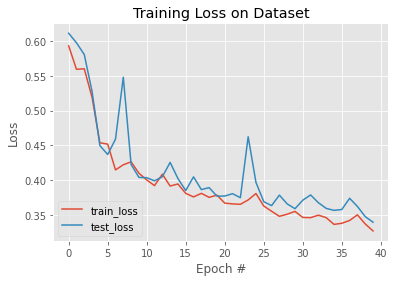

In [23]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)

# serialize the model to disk
torch.save(unet, MODEL_PATH)

## Using Our Trained U-Net Model for Prediction

In [24]:
# import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import os

In [25]:
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)

	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")

	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()

In [26]:
def make_predictions(model, imagePath):
	# set model to evaluation mode
	model.eval()

	# turn off gradient tracking
	with torch.no_grad():
		# load the image from disk, swap its color channels, cast it to float data type, and scale its pixel values
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image.astype("float32") / 255.0

		# resize the image and make a copy of it for visualization
		image = cv2.resize(image, (128, 128))
		orig = image.copy()

		# find the filename and generate the path to ground truth mask
		filename = imagePath.split(os.path.sep)[-1]
		groundTruthPath = os.path.join(MASK_DATASET_PATH, filename)

		# load the ground-truth segmentation mask in grayscale mode and resize it
		gtMask = cv2.imread(groundTruthPath, 0)
		gtMask = cv2.resize(gtMask, (INPUT_IMAGE_HEIGHT, INPUT_IMAGE_HEIGHT))
        
        # make the channel axis to be the leading one, add a batch dimension, create a PyTorch tensor, and flash it to the
		# current device
		image = np.transpose(image, (2, 0, 1))
		image = np.expand_dims(image, 0)
		image = torch.from_numpy(image).to(DEVICE)

		# make the prediction, pass the results through the sigmoid
		# function, and convert the result to a NumPy array
		predMask = model(image).squeeze()
		predMask = torch.sigmoid(predMask)
		predMask = predMask.cpu().numpy()

		# filter out the weak predictions and convert them to integers
		predMask = (predMask > THRESHOLD) * 255
		predMask = predMask.astype(np.uint8)

		# prepare a plot for visualization
		prepare_plot(orig, gtMask, predMask)

[INFO] loading up test image paths...
[INFO] load up model...


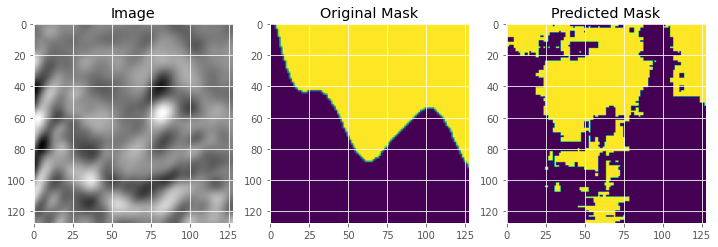

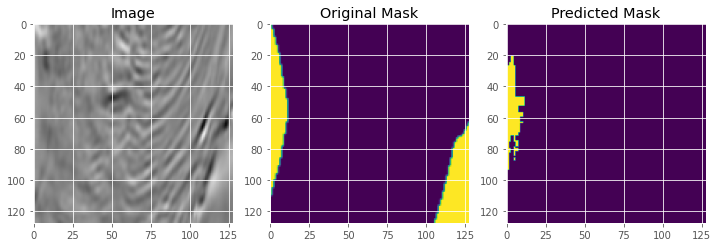

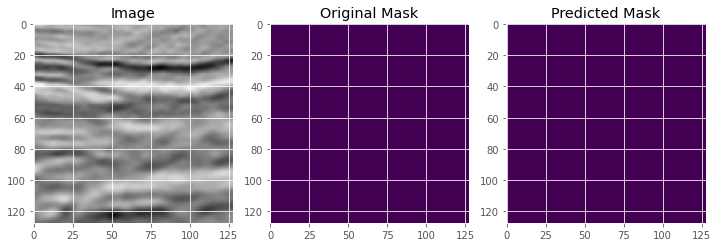

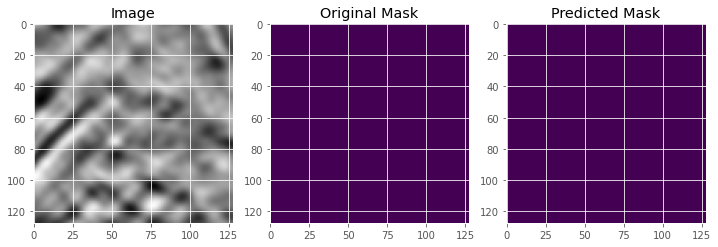

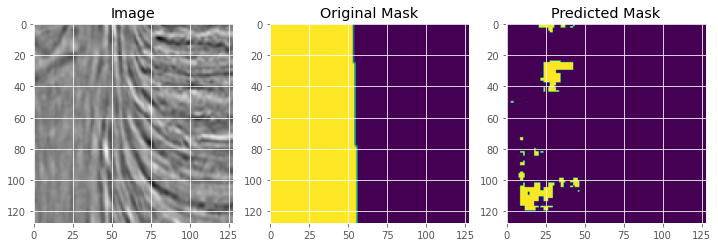

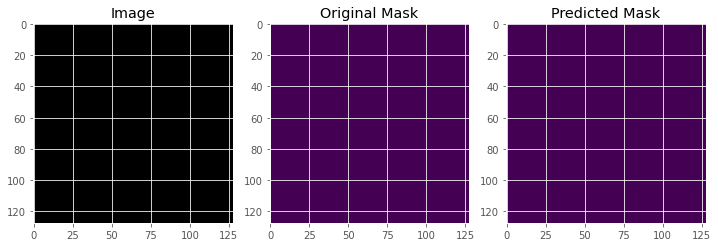

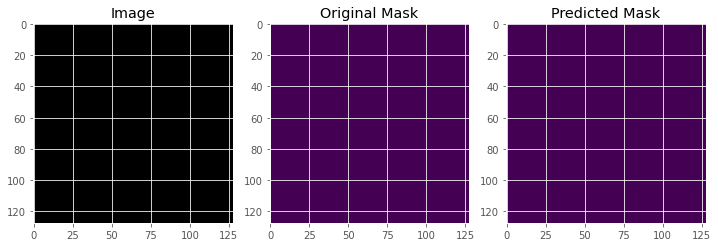

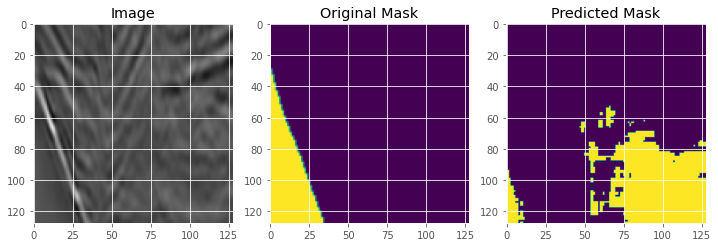

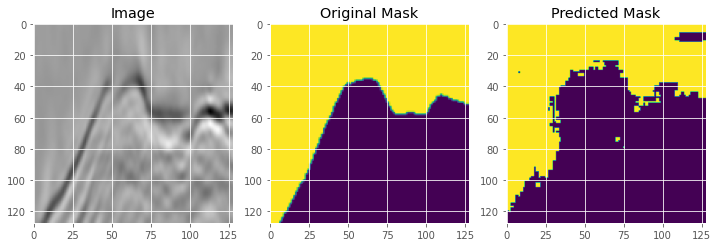

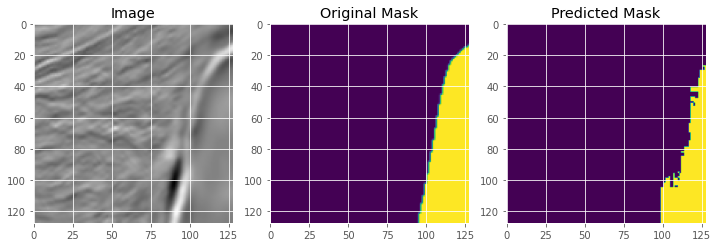

In [27]:
# load the image paths in our testing file and randomly select 10 image paths
print("[INFO] loading up test image paths...")
imagePaths = open(TEST_PATHS).read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size=10)

# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(MODEL_PATH).to(DEVICE)

# iterate over the randomly selected test image paths
for path in imagePaths:
	# make predictions and visualize the results
	make_predictions(unet, path)